In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

Load a cleaned set of edit conflicts which excludes the following sets:
1. all conflicts caused by known or suspected interface bugs (), and
1. "undebounced" duplicate conflicts logged at the same timestamp.

In [6]:
conflicts = spark.read.parquet("/user/awight/edit-conflicts/conflict_rev_details").cache()
total_count = conflicts.count()
total_count

47786

Where are conflicts happening?  On all wikis?

TODO:
* namespace pie
* scatterplot of wiki edit activity x rate of conflicts.  dot size is ~ wiki size

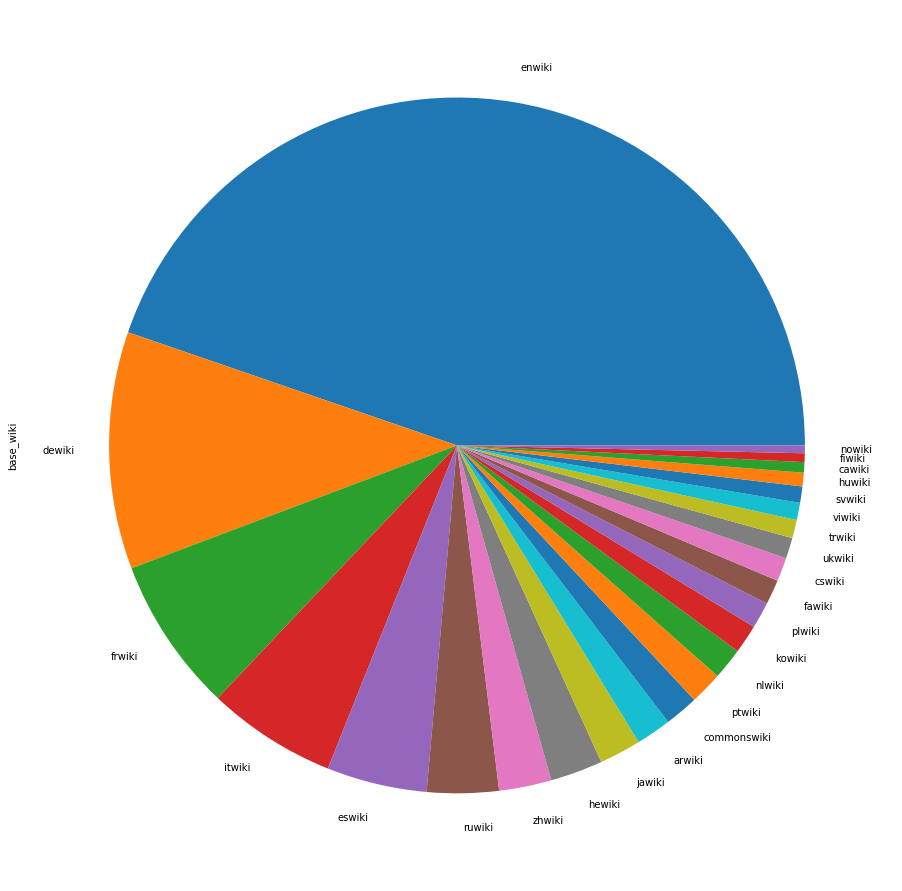

In [7]:
c = conflicts.toPandas()
c['base_wiki'].value_counts()[0:25].plot.pie(figsize=(16,16))

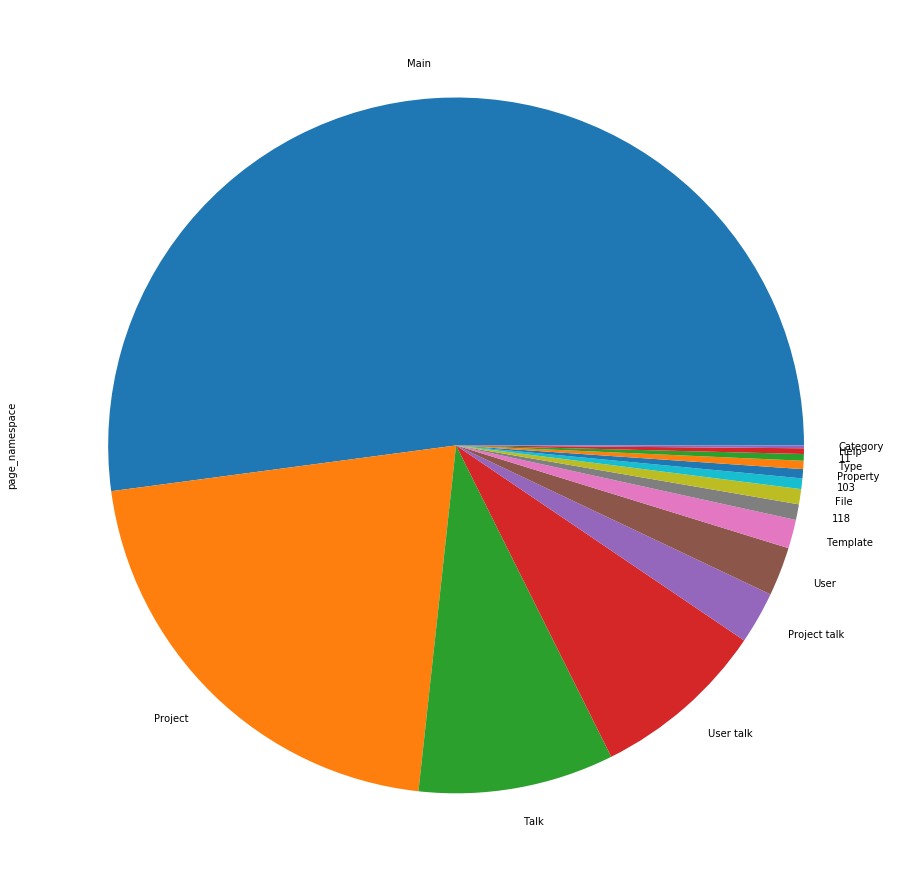

In [8]:
namespace_lookup = {
    0: 'Main',
    1: 'Talk',
    2: 'User',
    3: 'User talk',
    4: 'Project',
    5: 'Project talk',
    6: 'File',
    7: 'File talk',
    10: 'Template',
    12: 'Help',
    14: 'Category',
    15: 'Category talk',
    100: 'Relation',
    102: 'Property',
    104: 'Type',
}

c['page_namespace'].dropna().astype(int).apply(lambda id: namespace_lookup[id] if id in namespace_lookup else id).value_counts()[0:15].plot.pie(figsize=(16,16))

## Edit spacing in time
Are conflicting edits usually close together in time?  Is the page being editing very actively, in which case the base and other revisions would be very recent?  Is the base revision old, and the other and conflicting edits are close together?

TODO:
* Gather "starttime" metrics to see how long the editor spent on the edit page.

In [9]:
ages = pd.DataFrame(
    data={
        'base_age': (c['conflict_timestamp'] - c['base_timestamp']) / pd.Timedelta(1, unit='s'),
        'other_age': (c['conflict_timestamp'] - c['other_timestamp']) / pd.Timedelta(1, unit='s')
    }
)

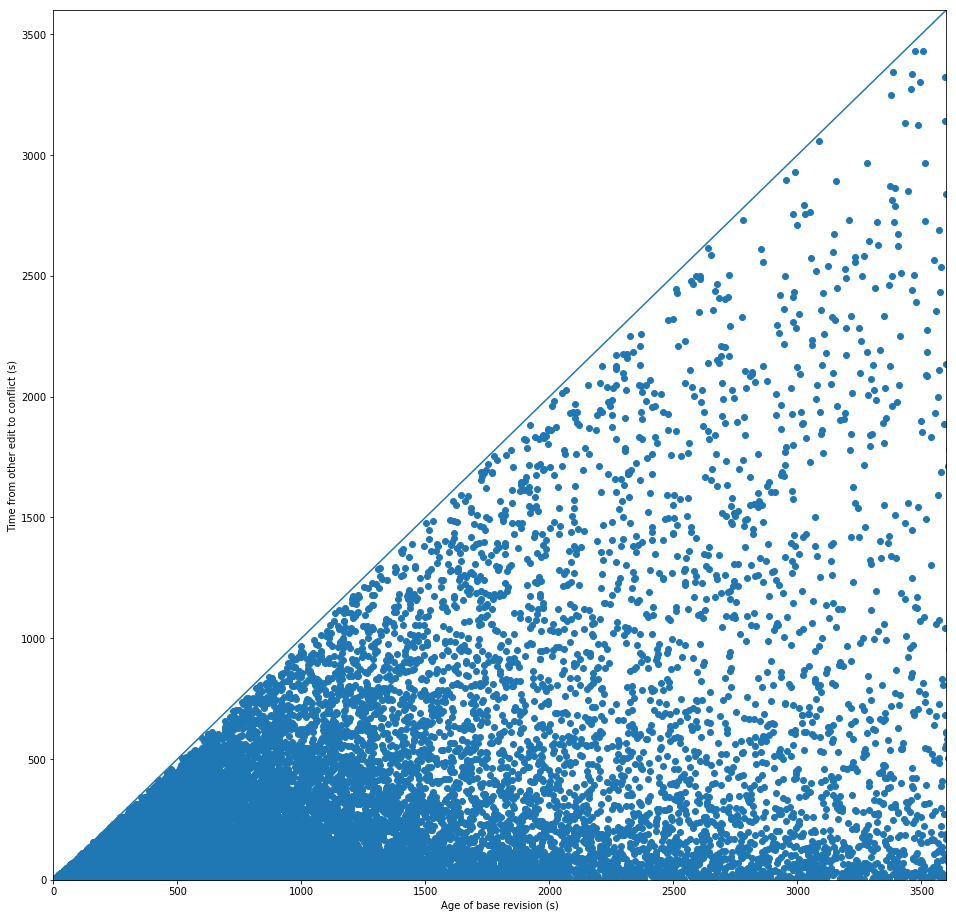

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 16)
ax.scatter(ages.base_age, ages.other_age)
ax.plot([0, 3600], [0, 3600])
ax.set_xlim(0, 3600)
ax.set_ylim(0, 3600)
ax.set_xlabel('Age of base revision (s)')
ax.set_ylabel('Time from other edit to conflict (s)')
plt.show()

In [11]:
relative_ages = pd.Series(
    data=ages.other_age / ages.base_age
).dropna()

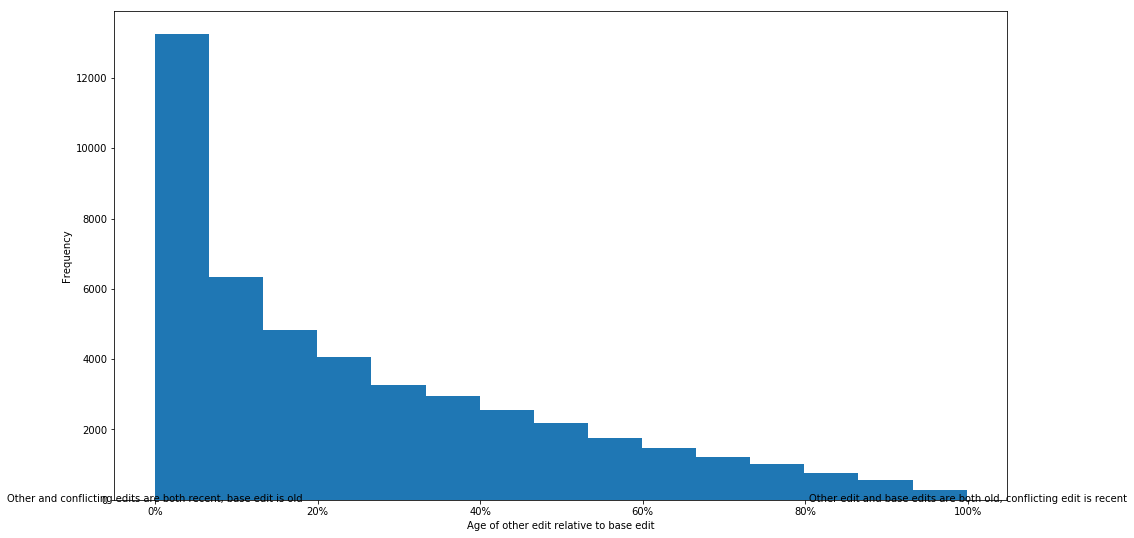

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.hist(relative_ages, 15)
ax.set_xlabel('Age of other edit relative to base edit')
ax.set_ylabel('Frequency')
ax.text(0, -50, 'Other and conflicting edits are both recent, base edit is old', ha='center')
ax.text(1, -50, 'Other edit and base edits are both old, conflicting edit is recent', ha='center')
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
plt.show()

## Double conflicts

How often do conflicts pile up due to rapid editing?  Is it common to experience a second edit conflict immediately after the first?

This case can be detected by joining the baseRevisionId of one conflict with the latestRevisionId of a previous conflict.

In [18]:
from pyspark.sql.functions import col

double_conflicts = conflicts.alias("first_conflict").join(
    conflicts.alias("second_conflict"),
    (col("first_conflict.wiki") == col("second_conflict.wiki"))
        & (col("first_conflict.latest_rev_id") == col("second_conflict.base_rev_id"))
)

print("{}, or {:.0%} of total".format(double_conflicts.count(), double_conflicts.count() / total_count))

8589, or 18% of total


That's dramatically likely to happen!

In [21]:
double_conflicts.groupBy(["first_conflict.wiki", "first_conflict.page_title"]).count().sort("count", ascending=False).show(n=20, truncate=False)

+--------+-----------------------------------------------------------------------------+-----+
|wiki    |page_title                                                                   |count|
+--------+-----------------------------------------------------------------------------+-----+
|enwiki  |April Fools/April Fools' Day 2020                                            |105  |
|enwiki  |Juanda International Airport                                                 |60   |
|enwiki  |April Fools/April Fools' Day 2020/The Great April Fools' Day Edit War of 2020|56   |
|dewiki  |Rüstungsindustrie                                                            |42   |
|enwiki  |2020 NFL Draft                                                               |35   |
|dewiki  |Zensur der Wikipedia                                                         |28   |
|enwiki  |Administrators' noticeboard/Incidents                                        |16   |
|testwiki|Adamw/sandbox                           

Okay, these look like real conflicts on popular pages.  But since we haven't filtered by user, all we know is that each editor experienced a conflict when saving, for two consecutive revisions.

What about people who saw two edit conflicts immediately after one another?  I think this includes people who couldn't save a conflict resolution because of a new conflict.

In [20]:
from pyspark.sql.functions import col

double_conflicts = conflicts.alias("first_conflict").join(
    conflicts.alias("second_conflict"),
    (col("first_conflict.wiki") == col("second_conflict.wiki"))
        & (col("first_conflict.other_user") == col("second_conflict.other_user"))
        & (col("first_conflict.latest_rev_id") == col("second_conflict.base_rev_id"))
)

print("{}, or {:.0%} of total".format(double_conflicts.count(), double_conflicts.count() / total_count))

1441, or 3% of total


Still a lot of inconvenience, but hopefully not too terrible for individuals.

## Self-conflicts

In [30]:
self_conflicts = conflicts.filter(
    conflicts.other_user == conflicts.next_user)
print("{}, or {:.0%} of total".format(self_conflicts.count(), self_conflicts.count() / total_count))

8549, or 18% of total


That's a lot of self-conflicts.  We should look at why this is happening.

## Hot pages
Which pages experience the most conflicts?

In [32]:
conflicts\
    .filter(conflicts.page_title.isNotNull())\
    .groupBy("wiki", "page_title")\
    .count().sort("count", ascending=False)\
    .show(n=20, truncate=False)

+------+-----------------------------------------------------------------------------+-----+
|wiki  |page_title                                                                   |count|
+------+-----------------------------------------------------------------------------+-----+
|enwiki|April Fools/April Fools' Day 2020                                            |1645 |
|itwiki|Kim Jong-un                                                                  |414  |
|enwiki|Administrators' noticeboard/Incidents                                        |363  |
|enwiki|April Fools/April Fools' Day 2020/The Great April Fools' Day Edit War of 2020|339  |
|enwiki|Irrfan Khan                                                                  |322  |
|dewiki|Vandalismusmeldung                                                           |310  |
|enwiki|Sandbox                                                                      |270  |
|enwiki|Teahouse                                                      